# Light GBM

In [1]:
import sys
import os

# Add the parent directory to the sys.path to avoid 'ModuleNotFoundError'
sys.path.append(os.path.abspath(os.path.join('..')))

import optuna
from lightgbm import LGBMClassifier
from src.preprocessing import *
from src.visualization import *
from src.trainer import *
from src.helpers import *
from src.config import *

In [2]:
model_name       = 'lgbm'
best_params_path = paths[model_name]['best_params']
model_path_list  = paths[model_name]['models']
pred_5folds_path = paths[model_name]['pred_5folds']
shap_fi_path     = paths[model_name]['shap_fi']
fi_path          = paths[model_name]['feature_importance']

## 1. Load data

In [3]:
# Get lists of data by folds
X_train_list = [pd.read_csv(path) for path in paths.get('X_train_paths')]
y_train_list = [pd.read_csv(path) for path in paths.get('y_train_paths')]
y_train_list = [y_train[TARGET].to_numpy() for y_train in y_train_list]

X_val_list   = [pd.read_csv(path) for path in paths.get('X_val_paths')]
y_val_list   = [pd.read_csv(path) for path in paths.get('y_val_paths')]
y_val_list   = [y_val[TARGET].to_numpy() for y_val in y_val_list]

## 2. Hyperparameters Tuning

In [4]:
def objective(trial):    
    param = {
        'objective'       : 'binary',
        'metric'          : 'binary_error',
        'boosting_type'   : 'gbdt',
        'verbose'         : -1,
        'verbose_eval'    : False,
        'num_leaves'      : trial.suggest_int('num_leaves', 2, 256),
        'learning_rate'   : trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
        'n_estimators'    : trial.suggest_int('n_estimators', 10, 1000),
        'max_depth'       : trial.suggest_int('max_depth', 1, 30),
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-3, 10.0),
        'subsample'       : trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
    }
    
    trainer = LGBMTrainer(model=LGBMClassifier(**param))
    mean_metrics, *_ = trainer.perform_cross_validation(
        X_train_list, y_train_list,
        X_val_list, y_val_list,
        verbose=0
    )
    avg = (mean_metrics.get('mean_accuracy') + mean_metrics.get('mean_f1_score') + mean_metrics.get('mean_roc_auc')) / 3
    return avg

In [5]:
HP_TUNING=False

if HP_TUNING:
    direction = 'maximize'
    n_trials  = 500
    n_jobs    = -1

    study = optuna.create_study(direction=direction)
    study.optimize(objective, n_trials=n_trials, n_jobs=n_jobs)

    best_params = study.best_trial.params
    best_params.update({
        'objective'    : 'binary',
        'metric'       : 'binary_error',
        'boosting_type': 'gbdt',
        'verbose'      : -1,
        'verbose_eval' : False,
    })
else:
    best_params = load_json(best_params_path)
    
best_params

{'num_leaves': 227,
 'learning_rate': 0.07701724900556504,
 'n_estimators': 943,
 'max_depth': 9,
 'min_child_weight': 5.63583349237318,
 'subsample': 0.6017475486818016,
 'colsample_bytree': 0.3136228504130327,
 'objective': 'binary',
 'metric': 'binary_error',
 'boosting_type': 'gbdt',
 'verbose': -1,
 'verbose_eval': False}

## 3. Train with 5-fold cross validation

In [6]:
trainer = LGBMTrainer(model=LGBMClassifier(**best_params))
mean_metrics, y_pred_list, y_pred_proba_list, fi_list = trainer.perform_cross_validation(
    X_train_list=X_train_list,
    y_train_list=y_train_list,
    X_val_list=X_val_list,
    y_val_list=y_val_list,
    #model_path_list=model_path_list, # uncomment if you want to save newly trained models
    verbose=1,
)

Fold 1/5:
	- ACCURACY: 0.8000
	- ROC_AUC: 0.8787
	- F1_SCORE: 0.7660
	- MSE: 0.1601
	- PRECISION: 0.8182
	- RECALL: 0.7200
	- SPECIFICITY: 0.8667

Fold 2/5:
	- ACCURACY: 0.9273
	- ROC_AUC: 0.9587
	- F1_SCORE: 0.9200
	- MSE: 0.0808
	- PRECISION: 0.9200
	- RECALL: 0.9200
	- SPECIFICITY: 0.9333

Fold 3/5:
	- ACCURACY: 0.9091
	- ROC_AUC: 0.9373
	- F1_SCORE: 0.9020
	- MSE: 0.0904
	- PRECISION: 0.8846
	- RECALL: 0.9200
	- SPECIFICITY: 0.9000

Fold 4/5:
	- ACCURACY: 0.8889
	- ROC_AUC: 0.8800
	- F1_SCORE: 0.8846
	- MSE: 0.1297
	- PRECISION: 0.8519
	- RECALL: 0.9200
	- SPECIFICITY: 0.8621

Fold 5/5:
	- ACCURACY: 0.8704
	- ROC_AUC: 0.9352
	- F1_SCORE: 0.8571
	- MSE: 0.1037
	- PRECISION: 0.8750
	- RECALL: 0.8400
	- SPECIFICITY: 0.8966

------------------------------
	- MEAN_ACCURACY: 0.8791
	- MEAN_ROC_AUC: 0.9180
	- MEAN_F1_SCORE: 0.8659
	- MEAN_MSE: 0.1129
	- MEAN_PRECISION: 0.8699
	- MEAN_RECALL: 0.8640
	- MEAN_SPECIFICITY: 0.8917


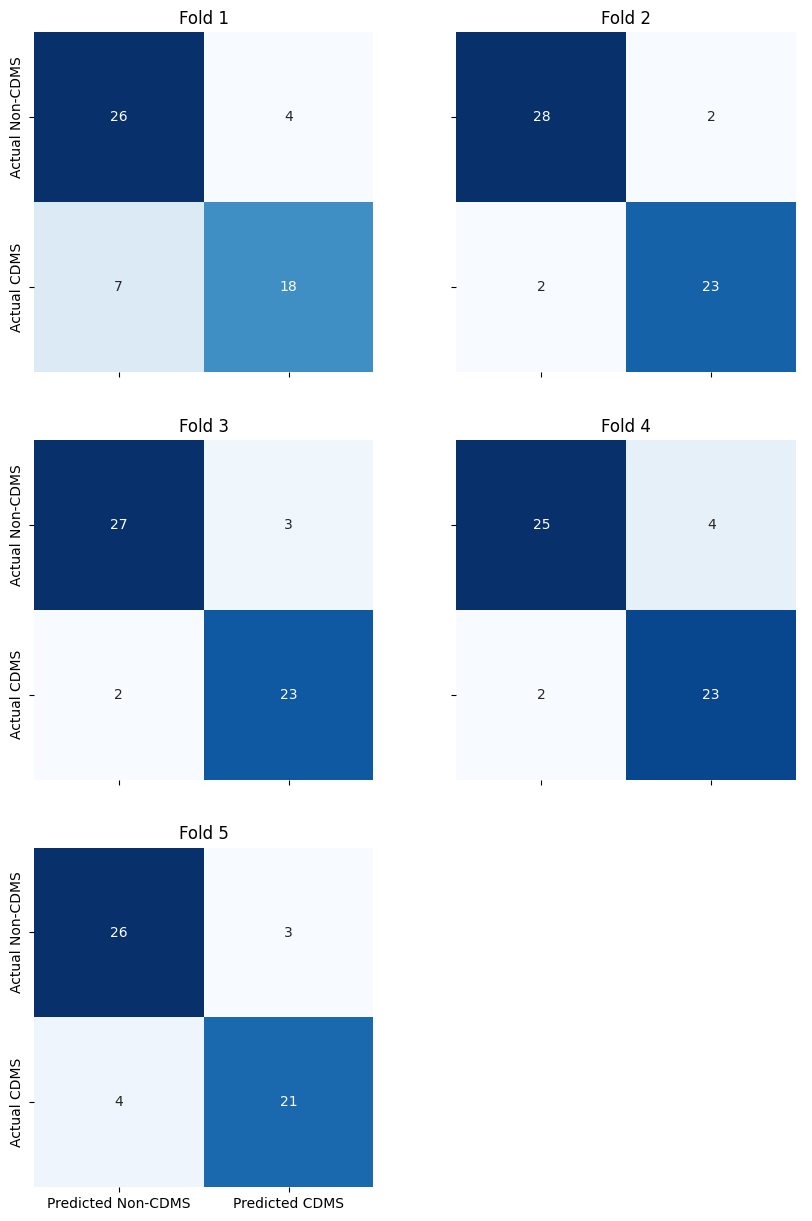

In [7]:
plot_confusion_matrix_folds(
    y_test_list=y_val_list,
    y_pred_list=y_pred_list,
)

## 4. Feature Importance

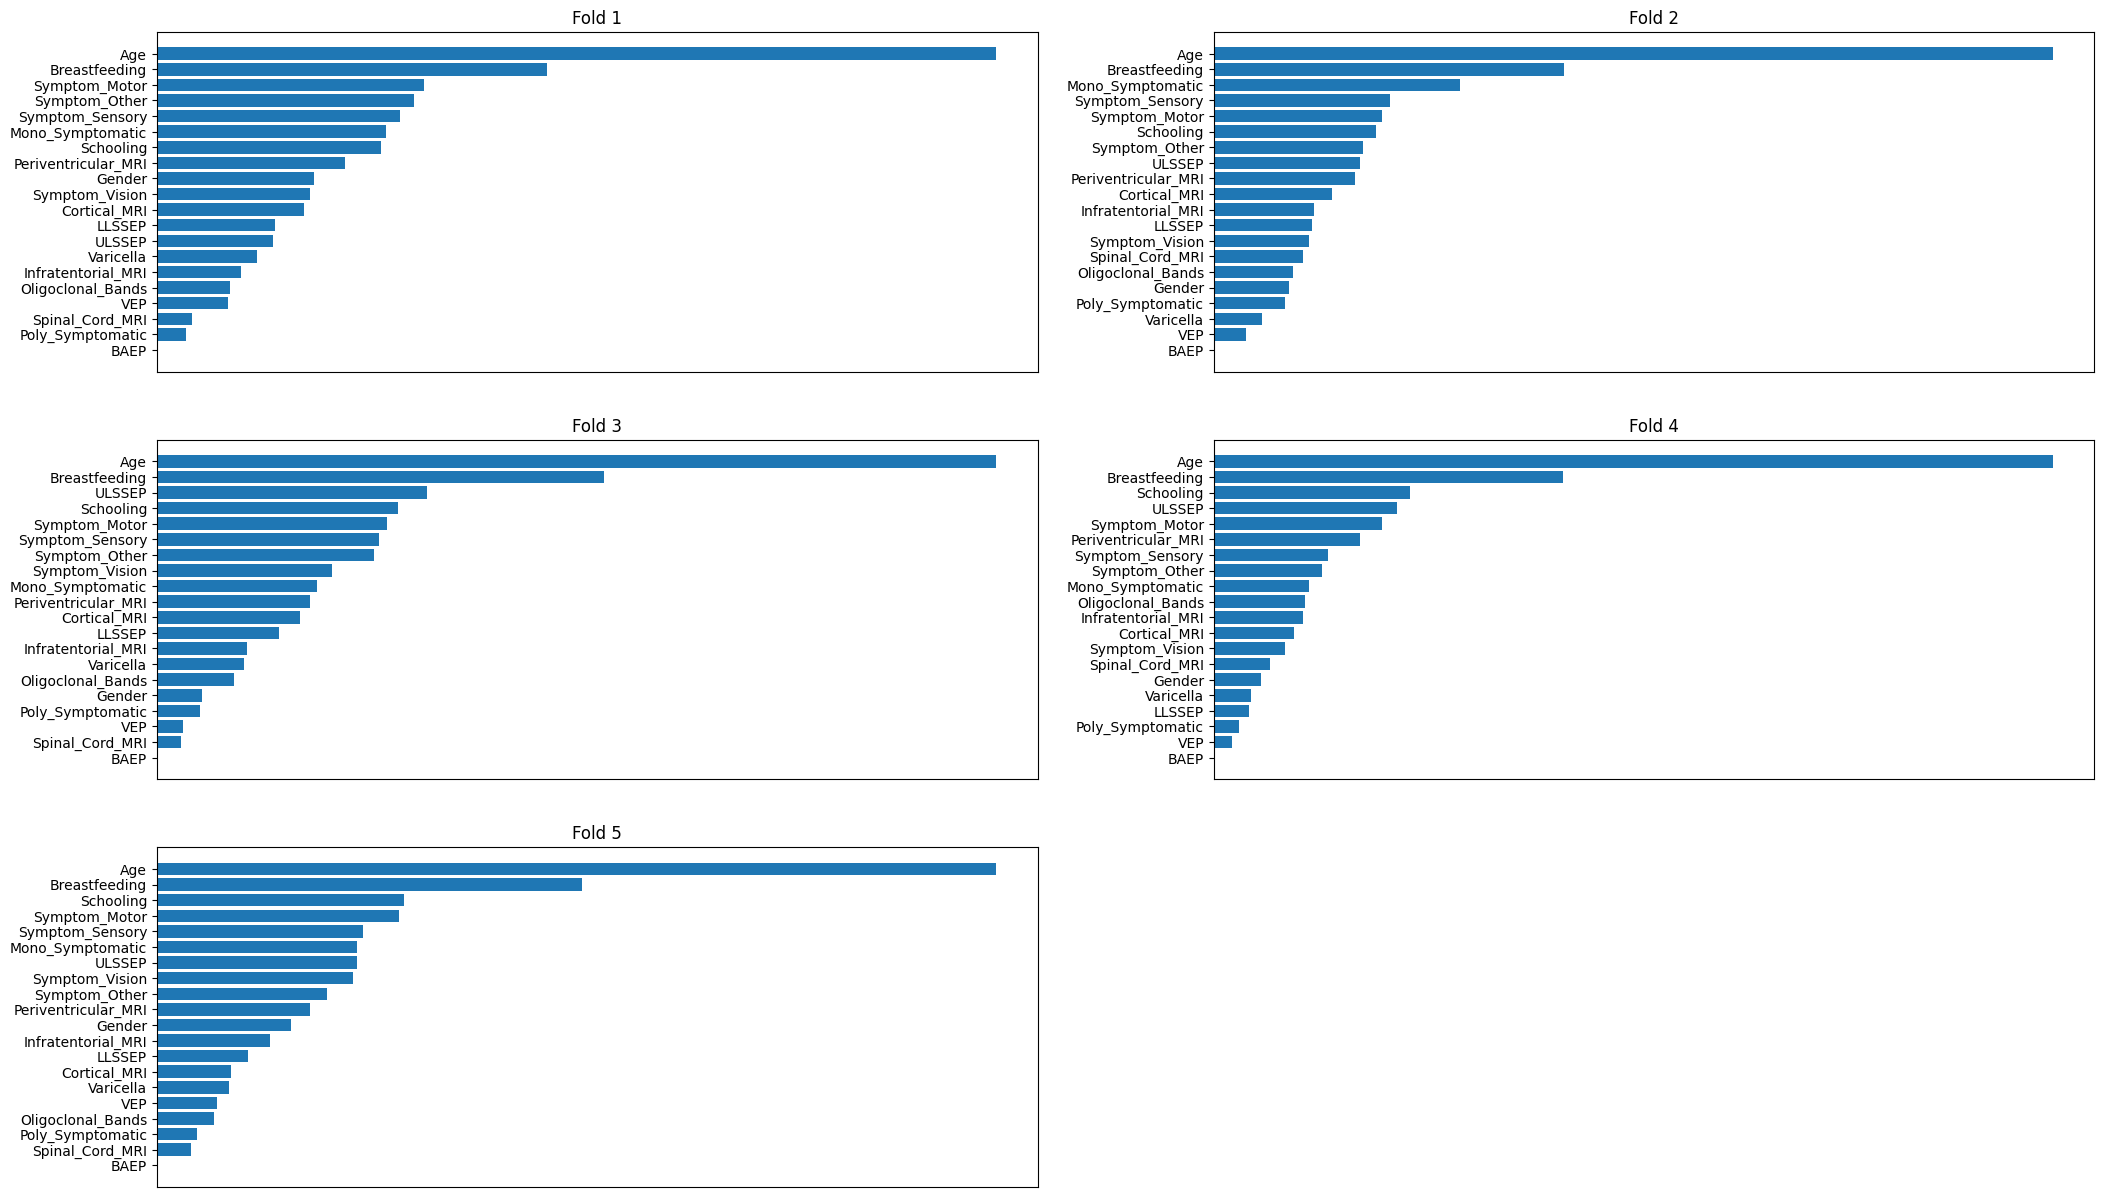

In [8]:
plot_catboost_feature_importance_folds(
    fi_list=fi_list,
    columns_folds=[X_train.columns for X_train in X_train_list]
)

In [9]:
fi_dfs = []
for fi, X_train_fold in zip(fi_list, X_train_list):
    fi_df = pd.DataFrame({'Feature Id': X_train_fold.columns, 'Importances': fi})
    fi_dfs.append(fi_df)

feature_importance = average_feature_importances(fi_dfs)
# feature_importance.to_csv(fi_path, index=False)
feature_importance

,Feature Id,Importances
0,Age,478.2
1,Breastfeeding,221.6
2,Schooling,120.6
3,Symptom_Motor,120.0
4,Symptom_Sensory,106.8
5,Mono_Symptomatic,104.4
6,ULSSEP,104.2
7,Symptom_Other,99.6
8,Periventricular_MRI,88.2
9,Symptom_Vision,76.0


## 5. Get predictions

In [10]:
analyzed_dfs = []

for fold in range(5):
    # Load data for the current fold
    X_train, y_train, X_val, y_val = load_data_fold(fold)

    # Load trained model for the current fold
    model = load_model_fold(fold, model_name=model_name)

    # Get predictions
    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)[:,-1]

    # Add ground truths and predictions to the current df
    analyzed_df = X_val.copy()
    analyzed_df['Actual'] = y_val
    analyzed_df['Predicted'] = y_pred
    analyzed_df['Predicted_Proba'] = y_pred_proba
    analyzed_dfs.append(analyzed_df)

analyzed_df_aggregated = pd.concat(analyzed_dfs, axis=0).reset_index(drop=True)
print(f'analyzed_df_aggregated.shape: {analyzed_df_aggregated.shape}')

# analyzed_df_aggregated.to_csv(pred_5folds_path, index=False)
# print(f'Save df to {pred_5folds_path}')

analyzed_df_aggregated.shape: (273, 23)


## 6. Explain with SHAP

In [11]:
import shap

models = [load_model_fold(fold, model_name) for fold in range(5)]
shap_values_folds = []

for fold in range(5):
    model = models[fold]
    X_val = X_val_list[fold]

    explainer = shap.TreeExplainer(model)
    sv = explainer.shap_values(X_val)
    mean_sv = np.mean(np.abs(sv), axis=0)
    shap_values_folds.append(mean_sv)

# Aggregate SHAP values across folds
aggregated_shap_values = np.mean(shap_values_folds, axis=0)

# Calculate mean absolute SHAP values for feature importance
feature_names = X_val_list[0].columns.to_list()
shap_feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': aggregated_shap_values
})

# Sort by importance
#shap_feature_importance.sort_values(by='Importance', ascending=False, inplace=True)
shap_feature_importance.to_csv(shap_fi_path, index=False)
shap_feature_importance

/home/luu/.local/share/virtualenvs/CIStoCDMS-fgf1c-B4/lib/python3.10/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/home/luu/.local/share/virtualenvs/CIStoCDMS-fgf1c-B4/lib/python3.10/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/home/luu/.local/share/virtualenvs/CIStoCDMS-fgf1c-B4/lib/python3.10/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed 

,Feature,Importance
0,Gender,0.395221
1,Age,0.511209
2,Schooling,0.900958
3,Breastfeeding,0.526751
4,Varicella,0.099447
5,Oligoclonal_Bands,0.582547
6,LLSSEP,0.287387
7,ULSSEP,0.148529
8,VEP,0.163693
9,BAEP,0.000000
